Import Modules

In [10]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import *
from keras.callbacks import History 
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
from io import BytesIO

Seed Random Values (Consistent Test Results)

In [11]:
from numpy.random import seed
from tensorflow.random import set_seed
set_seed(42)
seed(42)  

Import Model Input Data

In [12]:
all_model_input_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tech Project/Input Data/all_model_input_data.csv')
#uploaded = files.upload()
#all_model_input_data = pd.read_csv(BytesIO(uploaded['all_model_input_data.csv']))
print("Model Data Imported")

Model Data Imported


In [4]:
all_model_input_data.head()

,fips,date,county,state,cases,deaths,days_spreading,estimated_r_SIR1,estimated_r_ratio14,estimated_r_ratio8,poor-fair_health,obesity,below_18,over_65,smoking,drinking,Ethnic_Minority,uninsured,household_income,unemployment,% labor_force,rural-urban_code,urban-influence_code,population density,rural,% total cases,% total deaths,av_r_ratio8
0,53061.0,2020-01-21,Snohomish,Washington,1,0,0,1.044893,1.0,1.0,0.118657,0.29,0.227332,0.130403,0.131652,0.187944,0.245325,0.102859,87096.0,3.0,0.534574,1.0,1.0,67.17278,0.108195,0.248276,0.010008,2.68374
1,53061.0,2020-01-22,Snohomish,Washington,1,0,1,1.048949,1.0,1.0,0.118657,0.29,0.227332,0.130403,0.131652,0.187944,0.245325,0.102859,87096.0,3.0,0.534574,1.0,1.0,67.17278,0.108195,0.248276,0.010008,2.68374
2,53061.0,2020-01-23,Snohomish,Washington,1,0,2,1.053370,1.0,1.0,0.118657,0.29,0.227332,0.130403,0.131652,0.187944,0.245325,0.102859,87096.0,3.0,0.534574,1.0,1.0,67.17278,0.108195,0.248276,0.010008,2.68374
3,53061.0,2020-01-24,Snohomish,Washington,1,0,3,1.058190,1.0,1.0,0.118657,0.29,0.227332,0.130403,0.131652,0.187944,0.245325,0.102859,87096.0,3.0,0.534574,1.0,1.0,67.17278,0.108195,0.248276,0.010008,2.68374
4,53061.0,2020-01-25,Snohomish,Washington,1,0,4,1.063444,1.0,1.0,0.118657,0.29,0.227332,0.130403,0.131652,0.187944,0.245325,0.102859,87096.0,3.0,0.534574,1.0,1.0,67.17278,0.108195,0.248276,0.010008,2.68374


Format Data

In [13]:
# Remove R value outliers
max_r_value = 15
all_model_input_data_scaled = all_model_input_data.copy()
all_model_input_data_scaled['date'] = pd.to_datetime(all_model_input_data_scaled['date'])
all_model_input_data_scaled["estimated_r_ratio8"] = all_model_input_data_scaled["estimated_r_ratio8"].clip(upper=max_r_value)
all_model_input_data_scaled["estimated_r_ratio14"] = all_model_input_data_scaled["estimated_r_ratio14"].clip(upper=max_r_value)
all_model_input_data_scaled["estimated_r_SIR1"] = all_model_input_data_scaled["estimated_r_SIR1"].clip(upper=max_r_value)

# Select Features and target
target_column = 'estimated_r_ratio8'
features = ['days_spreading','poor-fair_health','obesity','smoking','drinking','Ethnic_Minority','below_18','over_65','uninsured','household_income','unemployment','% labor_force','population density','rural','% total cases',	'% total deaths','rural-urban_code','urban-influence_code'] # ,'rural-urban_code','urban-influence_code'

# Scale features and target from 0-1 for model input
scale_columns = features.copy()
scale_columns.remove('rural-urban_code')
scale_columns.remove('urban-influence_code')
scale_columns.append(target_column)

# Save the transform of the target column so we can reverse it after our predicitions
target_offset = all_model_input_data_scaled[target_column].min()  
target_multiplier = (all_model_input_data_scaled[target_column]-target_offset).max() 

for col in scale_columns:
  all_model_input_data_scaled[col] -= all_model_input_data_scaled[col].min() # Subtract min value
  all_model_input_data_scaled[col] /= all_model_input_data_scaled[col].max() # Divide by max value

print("Target Scaled By Subtracting: {} then Dividing by: {}".format(target_offset,target_multiplier))

# One-hot encode county urbanisation codes
ui_onehot = pd.get_dummies(all_model_input_data_scaled['urban-influence_code'],prefix='u-i_code',drop_first=False)
ru_onehot = pd.get_dummies(all_model_input_data_scaled['rural-urban_code'],prefix='r-u_code',drop_first=False)
all_model_input_data_scaled_enc = all_model_input_data_scaled.drop('urban-influence_code',axis = 1).drop('rural-urban_code',axis=1)
all_model_input_data_scaled_enc = all_model_input_data_scaled_enc.join(ui_onehot).join(ru_onehot)

# Train Test Split
date_threshold = datetime(year=2020, month=5, day=17)
train_data = all_model_input_data_scaled_enc[all_model_input_data_scaled_enc["date"] < date_threshold]
test_data = all_model_input_data_scaled_enc[all_model_input_data_scaled_enc["date"] >= date_threshold]

'''
# Alternative Train-Test split with shuffling
train_ratio = 0.8
train_data = all_model_input_data_scaled_enc.sample(frac=train_ratio,random_state=42) #random state is a seed value
test_data = all_model_input_data_scaled_enc.drop(train_data.index)
'''

print("Train Length: {}\nTest Length: {}".format(train_data.date.count(),test_data.date.count()))
train_data.head()

Target Scaled By Subtracting: 0.25 then Dividing by: 14.75
Train Length: 146112
Test Length: 30250


,fips,date,county,state,cases,deaths,days_spreading,estimated_r_SIR1,estimated_r_ratio14,estimated_r_ratio8,poor-fair_health,obesity,below_18,over_65,smoking,drinking,Ethnic_Minority,uninsured,household_income,unemployment,% labor_force,population density,rural,% total cases,% total deaths,av_r_ratio8,u-i_code_1.0,u-i_code_2.0,u-i_code_3.0,u-i_code_4.0,u-i_code_5.0,u-i_code_6.0,u-i_code_7.0,u-i_code_8.0,u-i_code_9.0,u-i_code_10.0,u-i_code_11.0,u-i_code_12.0,r-u_code_1.0,r-u_code_2.0,r-u_code_3.0,r-u_code_4.0,r-u_code_5.0,r-u_code_6.0,r-u_code_7.0,r-u_code_8.0,r-u_code_9.0
0,53061.0,2020-01-21,Snohomish,Washington,1,0,0.000000,1.044893,1.0,0.050847,0.11024,0.428969,0.457009,0.158569,0.198793,0.47233,0.244672,0.125993,0.536631,0.094675,0.622804,0.026745,0.108195,0.043422,0.06408,2.68374,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,53061.0,2020-01-22,Snohomish,Washington,1,0,0.007874,1.048949,1.0,0.050847,0.11024,0.428969,0.457009,0.158569,0.198793,0.47233,0.244672,0.125993,0.536631,0.094675,0.622804,0.026745,0.108195,0.043422,0.06408,2.68374,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,53061.0,2020-01-23,Snohomish,Washington,1,0,0.015748,1.053370,1.0,0.050847,0.11024,0.428969,0.457009,0.158569,0.198793,0.47233,0.244672,0.125993,0.536631,0.094675,0.622804,0.026745,0.108195,0.043422,0.06408,2.68374,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,53061.0,2020-01-24,Snohomish,Washington,1,0,0.023622,1.058190,1.0,0.050847,0.11024,0.428969,0.457009,0.158569,0.198793,0.47233,0.244672,0.125993,0.536631,0.094675,0.622804,0.026745,0.108195,0.043422,0.06408,2.68374,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,53061.0,2020-01-25,Snohomish,Washington,1,0,0.031496,1.063444,1.0,0.050847,0.11024,0.428969,0.457009,0.158569,0.198793,0.47233,0.244672,0.125993,0.536631,0.094675,0.622804,0.026745,0.108195,0.043422,0.06408,2.68374,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Format data for model

In [14]:
# Select Final Feature columns
final_features = scale_columns.copy()
final_features.remove(target_column)
for col in ui_onehot.columns: 
  final_features.append(col)
for col in ru_onehot.columns: 
  final_features.append(col)

# Extract Features and Target
train_y = train_data[target_column]
test_y = test_data[target_column]
train_x = train_data[final_features]
test_x = test_data[final_features]

# Convert to np arrays for model input
train_y_list = train_y.values
test_y_list = test_y.values
train_x_list = train_x.values
test_x_list = test_x.values

Define Neural Network Model Topology

In [15]:
# Define Model Topology
num_input_nodes = len(test_x_list[0])
print(num_input_nodes)

# Use a Deep RNN
model = Sequential()

# Input and hidden layers :
model.add(Dense(50, input_dim=num_input_nodes, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))

# Output neuron with linear activation function
model.add(Dense(1, activation='linear')) 

# Use MAE for our loss function
model.compile(loss='mean_absolute_error', optimizer='adam')

'''
# Example of a shallower model:
model.add(Dense(32, input_dim=num_input_nodes, activation='relu'))
model.add(Dense(1, activation='linear'))
'''
'''
# Example of a simple perceptron:
model.add(Dense(1, input_dim=num_input_nodes, activation='linear'))
'''


37


"\n# Example of a simple perceptron:\nmodel.add(Dense(1, input_dim=num_input_nodes, activation='linear'))\n"

Train Model

In [16]:
# Fit model
num_epochs = 30
validation_split = 0.2
training_metrics = model.fit(train_x_list,train_y_list,epochs=num_epochs,validation_split=validation_split,shuffle=True,verbose=2)

Train on 116889 samples, validate on 29223 samples
Epoch 1/30
 - 6s - loss: 0.0507 - val_loss: 0.0467
Epoch 2/30
 - 6s - loss: 0.0476 - val_loss: 0.0431
Epoch 3/30
 - 6s - loss: 0.0467 - val_loss: 0.0461
Epoch 4/30
 - 6s - loss: 0.0462 - val_loss: 0.0434
Epoch 5/30
 - 6s - loss: 0.0457 - val_loss: 0.0440
Epoch 6/30
 - 6s - loss: 0.0452 - val_loss: 0.0429
Epoch 7/30
 - 6s - loss: 0.0447 - val_loss: 0.0446
Epoch 8/30
 - 6s - loss: 0.0442 - val_loss: 0.0438
Epoch 9/30
 - 6s - loss: 0.0439 - val_loss: 0.0449
Epoch 10/30
 - 6s - loss: 0.0434 - val_loss: 0.0453
Epoch 11/30
 - 6s - loss: 0.0429 - val_loss: 0.0452
Epoch 12/30
 - 6s - loss: 0.0424 - val_loss: 0.0452
Epoch 13/30
 - 6s - loss: 0.0420 - val_loss: 0.0459
Epoch 14/30
 - 6s - loss: 0.0417 - val_loss: 0.0450
Epoch 15/30
 - 6s - loss: 0.0413 - val_loss: 0.0453
Epoch 16/30
 - 6s - loss: 0.0409 - val_loss: 0.0433
Epoch 17/30
 - 6s - loss: 0.0406 - val_loss: 0.0465
Epoch 18/30
 - 6s - loss: 0.0403 - val_loss: 0.0459
Epoch 19/30
 - 6s - lo

Veiw Training Metrics

In [9]:
# Few Loss over epochs
sns.set(style="darkgrid")
loss_values = training_metrics.history['loss']
#loss_values_1 = training_metrics_1.history['loss']
#loss_values_2 = training_metrics_2.history['loss']
#loss_values_3 = training_metrics_3.history['loss']
#val_loss_values = training_metrics.history['val_loss']
epoch_values = [i for i in range(1,num_epochs+1)]

plt.figure(figsize=(10,10))
plt.plot(epoch_values, loss_values)
#plt.plot(epoch_values, loss_values_1, color='orange', label = 'No Deep Layers')
#plt.plot(epoch_values, loss_values_2, color='deeppink', label = '1 Deep Layer')
#plt.plot(epoch_values, loss_values_3, color='blue', label = '3 Deep Layers')

#plt.ylabel('Loss Value')
plt.title("Neural Network Training Loss" )
plt.xlabel('Training Iteration')
#plt.legend()
plt.show()

NameError: ignored

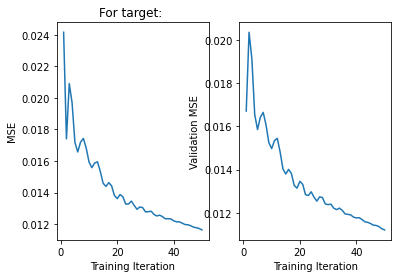

In [ ]:
# Here is an example of an early model I tested - which showed bag overfitting (large loss after each shuffle suggests model is memorising the test set exactly)

Evaluate Model on Test Data

In [34]:
# Make prediction
test_prediction = model.predict(test_x_list)
test_prediction

array([[0.31484795],
       [0.3160508 ],
       [0.24644081],
       ...,
       [0.05316366],
       [0.05419896],
       [0.05746151]], dtype=float32)

In [35]:
# Combine to test_data
predicted_r_data = test_y.copy()
predicted_r_data = predicted_r_data.to_frame()
predicted_r_data[target_column +'_pred'] = test_prediction
predicted_r_data *= target_multiplier
predicted_r_data += target_offset
predicted_r_data.head()
predicted_r_data['absolute_error'] = abs(predicted_r_data[target_column] - predicted_r_data[target_column +'_pred'])
predicted_r_data['square_error'] = (predicted_r_data[target_column] - predicted_r_data[target_column +'_pred'])**2
print("Mean Absolute Error: {}".format(predicted_r_data['absolute_error'].mean()))
print("Mean Square Error: {}".format(predicted_r_data['square_error'].mean()))

Mean Absolute Error: 0.5311081185419724
Mean Square Error: 1.719360716405997


In [30]:
# Join model predictions with original data for comparison
predicted_r_data_NN = test_data[['fips','date']].join(predicted_r_data)
predicted_r_data_NN.head()

,fips,date,estimated_r_ratio8,estimated_r_ratio8_pred,absolute_error,square_error
5,53061.0,2020-01-26,1.0,6.985419,5.985419,35.825240
10,53061.0,2020-01-31,1.0,5.303097,4.303097,18.516641
15,53061.0,2020-02-05,1.0,3.611344,2.611344,6.819119
16,53061.0,2020-02-06,1.0,3.423548,2.423548,5.873584
18,53061.0,2020-02-08,1.0,3.080681,2.080681,4.329235


In [ ]:
# Export this data
from google.colab import files

predicted_r_data__NN_file = predicted_r_data_NN.to_csv("predicited_r_data_NN.csv")
files.download("predicited_r_data_NN.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>